In [ ]:
! pip install transformers

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from torch import nn

In [ ]:
from transformers import ConvNextConfig, UperNetConfig, UperNetForSemanticSegmentation

backbone_config = ConvNextConfig(out_features=["stage1", "stage2", "stage3", "stage4"])

config = UperNetConfig(backbone_config=backbone_config)

segmentation_model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-tiny")

In [ ]:
# Number of output channels equal to number of classes

num_classes = 1 # Our task is Binary Classification --> number of channels = 1
output_channels = num_classes
segmentation_model.decode_head.classifier = nn.Conv2d(512, output_channels, kernel_size=(1, 1), stride=(1, 1))
segmentation_model.auxiliary_head.classifier = nn.Conv2d(256, output_channels, kernel_size=(1, 1), stride=(1, 1))

In [ ]:
# Verify the model output
with torch.no_grad():
    seg_output = segmentation_model(torch.zeros(size= (4, 3, 224, 224)))

seg_output.logits.shape

torch.Size([4, 1, 224, 224])

In [ ]:
# Freeze the backbone (Feature extractor) parameters during training
for name, param in segmentation_model.named_parameters():
    if ("decode_head" not in name) and ("auxiliary_head" not in name):
        param.requires_grad = False

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from torchvision.models import segmentation
from torchvision.io import read_image
import os
from PIL import Image
import glob

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SegDataset(Dataset):
    
    def __init__(self, parentDir, imageDir, maskDir):
        self.imageList = glob.glob(parentDir+'/'+imageDir+'/*')
        self.imageList.sort()
        self.maskList = glob.glob(parentDir+'/'+maskDir+'/*')
        self.maskList.sort()
    def __getitem__(self, index):
        
        preprocess = transforms.Compose([
                                    transforms.Resize((256,256), 2),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        
        X = Image.open(self.imageList[index]).convert('RGB')
        X = preprocess(X)
        
        trfresize = transforms.Resize((256, 256), 2)
        trftensor = transforms.ToTensor()
        
        yimg = Image.open(self.maskList[index]).convert('L')
        y1 = trftensor(trfresize(yimg))
        y1 = y1.type(torch.BoolTensor)
        y2 = torch.bitwise_not(y1)
        y = torch.cat([y2, y1], dim=0)
        
        return X, y1.float()
            
    def __len__(self):
        return len(self.imageList)
    
dataset = SegDataset(parentDir= "data/data",imageDir= "images", maskDir= "masks")


In [ ]:
train_ratio = 0.7 
test_ratio = 0.3  

# Calculate the sizes of training and testing sets
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Randomly split the dataset into training and testing sets
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing sets
dataloader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)

In [ ]:
# Define the model
model = segmentation_model

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move the model to the device
model = model.to(device)

# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:

        # Move images and masks to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)['logits']

        #print(f"output shape: {outputs.shape}")

        # Compute the loss
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)
        
        #print(loss.item())
    # Print the epoch loss
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Create checkpoint after every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint_name = f"convNextmodel_18may_epoch_{epoch}.pth"
        
        # Save the model parameters
        torch.save(model.state_dict(), checkpoint_name)

# Save the final trained model
torch.save(model.state_dict(), "convnext_segmentation_model.pth")

Epoch 1/119, Loss: 0.2777
Epoch 2/119, Loss: 0.1387
Epoch 3/119, Loss: 0.1166
Epoch 4/119, Loss: 0.1004
Epoch 5/119, Loss: 0.0904
Epoch 6/119, Loss: 0.0813
Epoch 7/119, Loss: 0.0775
Epoch 8/119, Loss: 0.0728
Epoch 9/119, Loss: 0.0720
Epoch 10/119, Loss: 0.0683
Epoch 11/119, Loss: 0.0625
Epoch 12/119, Loss: 0.0579
Epoch 13/119, Loss: 0.0598
Epoch 14/119, Loss: 0.0566
Epoch 15/119, Loss: 0.0545
Epoch 16/119, Loss: 0.0532
Epoch 17/119, Loss: 0.0527
Epoch 18/119, Loss: 0.0548
Epoch 19/119, Loss: 0.0501
Epoch 20/119, Loss: 0.0467
Epoch 21/119, Loss: 0.0481
Epoch 22/119, Loss: 0.0472
Epoch 23/119, Loss: 0.0447
Epoch 24/119, Loss: 0.0432
Epoch 25/119, Loss: 0.0421
Epoch 26/119, Loss: 0.0428
Epoch 27/119, Loss: 0.0424
Epoch 28/119, Loss: 0.0408
Epoch 29/119, Loss: 0.0405
Epoch 30/119, Loss: 0.0387
Epoch 31/119, Loss: 0.0383
Epoch 32/119, Loss: 0.0376
Epoch 33/119, Loss: 0.0371
Epoch 34/119, Loss: 0.0383
Epoch 35/119, Loss: 0.0406
Epoch 36/119, Loss: 0.0385
Epoch 37/119, Loss: 0.0362
Epoch 38/1

### **Load Trained model**

In [ ]:
# Use this cell to load previously trained model
path = './segmentation_model.pth'

model = segmentation_model

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
import torch
import torch.nn.functional as F

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for image, mask_true in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
            #image, mask_true = batch['image'], batch['mask']

            # move images and labels to correct device and type
            # image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            image = image.to(device=device)

            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)['logits']
            print(f"mask predict shape: {mask_pred.shape}")
            print(f"mask predict: {mask_pred}")

            if net.n_classes == 1:
                assert mask_true.min() >= 0 and mask_true.max() <= 1, 'True mask indices should be in [0, 1]'
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                assert mask_true.min() >= 0 and mask_true.max() < net.n_classes, 'True mask indices should be in [0, n_classes['
                # convert to one-hot format
                mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:], mask_true[:, 1:], reduce_batch_first=False)

    net.train()
    return dice_score / max(num_val_batches, 1)

In [ ]:
import torch

def calculate_iou(predicted_mask, ground_truth_mask):
    # Threshold predicted mask to binary values
    predicted_mask = (predicted_mask > 0.5).float()

    # Calculate intersection and union
    intersection = torch.sum(predicted_mask * ground_truth_mask)
    union = torch.sum(predicted_mask) + torch.sum(ground_truth_mask) - intersection

    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero

    return iou

In [ ]:
# Create an iterator from the DataLoader
data_iter = iter(test_loader)

# Randomly sample one item
sample = next(data_iter)

# Access the input data and labels
image = sample[0]
mask = sample[1]

pred = model(image[0].unsqueeze(0))['logits']

predicted_mask = torch.sigmoid(pred)
ground_truth_mask = mask[0]

iou = calculate_iou(predicted_mask, ground_truth_mask)
print("IoU:", iou.item())

IoU: 0.8630405068397522


In [ ]:
data_iter = iter(test_loader)
iou_sum = 0

for i in range(len(data_iter)-1):
  # Randomly sample one item
  sample = next(data_iter)

  # Access the input data and labels
  image = sample[0]
  mask = sample[1]

  for j in range(4):
    pred = model(image[j].unsqueeze(0))['logits']

    predicted_mask = torch.sigmoid(pred)
    ground_truth_mask = mask[j]

    iou = calculate_iou(predicted_mask, ground_truth_mask)

    print("IoU:", iou.item())

    iou_sum += iou.item()

print("Avg_IoU:", iou.item()/(i*4))

In [ ]:
print("Avg_IoU:", iou_sum/(i*4))

Avg_IoU: 0.8470133911211823


(1, 1, 256, 256)
(256, 256, 4)


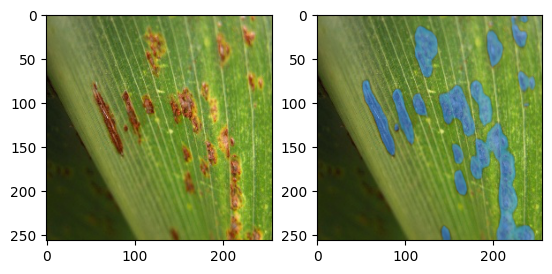

In [ ]:
import matplotlib.pyplot as plt

preprocess = transforms.Compose([transforms.Resize((224,224), 2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image = Image.open('./data/data/images/00585.jpg')
input  = preprocess((image))

input = input.to(device)

model.to(device)
model.eval()
with torch.no_grad():
  pred = model(input.unsqueeze(0))

pred = (transforms.Resize((np.array(image).shape[:2]), 2)(torch.sigmoid(pred['logits']))).cpu().detach().numpy()
print(pred.shape)
fig, (axes1, axes2) = plt.subplots(1, 2)
axes1.imshow(np.array(image))
axes2.imshow(np.array(image))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    print(mask_image.shape)
    #print(mask_image)
    ax.imshow(mask_image)

show_mask(pred, axes2)

In [ ]:
# Try iterating over test data to see type of images, size and other features for those with IoU less than certain threshold. Check same thing with other models as well.
# Compare them. It might show how CNN vs ViT based models perform for certain features.